In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime
from joblib import Parallel, delayed

Capture hides output

In [2]:
%%capture
# %run cowling_approximation2.ipynb
# %run cowling_approximation2_invert_dedp.ipynb
%run cowling_approximation.ipynb

In [3]:
def process(k):
    df = pd.read_csv(path)
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)

    # Initial Conditions
    km2cm = 1e5
    r_i = 1
    p0 = p[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3


    omega = 2e3*(2*np.pi) #Arbitrary guess
    l=2

    v0 = -1 # Two step integration optimization: similar to phi previously.

    W0 = 1
    U0 = W0/(l * np.exp(v0))


    init_VEC = [p_c, m0, v0, W0, U0]
    p_min = min(p) 
    
#     p_smooth, dedp = dedp_arr(p, EOS)
#     dedp_EQ = get_dedp(dedp, p_smooth)
    dedp_EQ = None
    
    # Integrate
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, 
                                 omega, dedp_EQ,
                               l = l, n_iter_max = 2000)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)

    # Computer new v0, W0, U0
    v_ext = np.log(schild) #At surface
    v_int = v_R #At surface
    delta_v = v_int - v_ext
    v0 =  v0 - delta_v

    W0 = 1
    U0 = W0/(l * np.exp(v0))
    init_VEC = [p_c, m0, v0, W0, U0]

    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, 
                               dedp_EQ, l = l)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)
    
    def minimize_boundary_mass_plot(params, p = p, EOS = EOS):
        # Repeat integration

        omega = params

        # Integrate
        p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega,dedp_EQ, l = l)

        max_idx = np.argmax(m)
        m_R = m.max() # In units of msun
        r_R = r_arr[max_idx] # In units of km
        p_R = p[max_idx] #cgs
        ec_R = EOS(p_R) #cgs
        u_R = u[max_idx] #cgs
        v_R = v[max_idx]
        w_R = w[max_idx]

        loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
        return loss

    omega_guess = 2e3*(2*np.pi)
    init_guess = [omega_guess]
    res = minimize(minimize_boundary_mass_plot, x0 = init_guess, 
                   method='Nelder-Mead', 
                   options = {"disp": False, "maxiter":15},
                   tol = 1)

    omg = res.x[0]
    f = omg/(2*np.pi)
    return f, m_R, r_R

In [4]:
f_mode_list = []
mass_list = []
radius_list = []

ind_start = -2
ind_stop = -1200
jump = 30 # Default should be 1 for small EOS data
print(f"Total ~ {round(abs(ind_start-ind_stop)/jump)}")

vals = range(ind_stop, ind_start+1, 1)[::-jump]

results = Parallel(n_jobs=-2, 
                   verbose=10, 
                   max_nbytes='8M')(delayed(process)(k) for k in vals)

Total ~ 40


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-2)]: Done  32 out of  40 | elapsed:   32.4s remaining:    8.1s
[Parallel(n_jobs=-2)]: Done  37 out of  40 | elapsed:   38.3s remaining:    3.1s
[Parallel(n_jobs=-2)]: Done  40 out of  40 | elapsed:   38.7s finished


In [5]:
mass_arr = np.array(results).T[1]
f_mode_arr = np.array(np.array(results).T[0])
radius_arr = np.array(results).T[2]
hz2khz = 1e-3

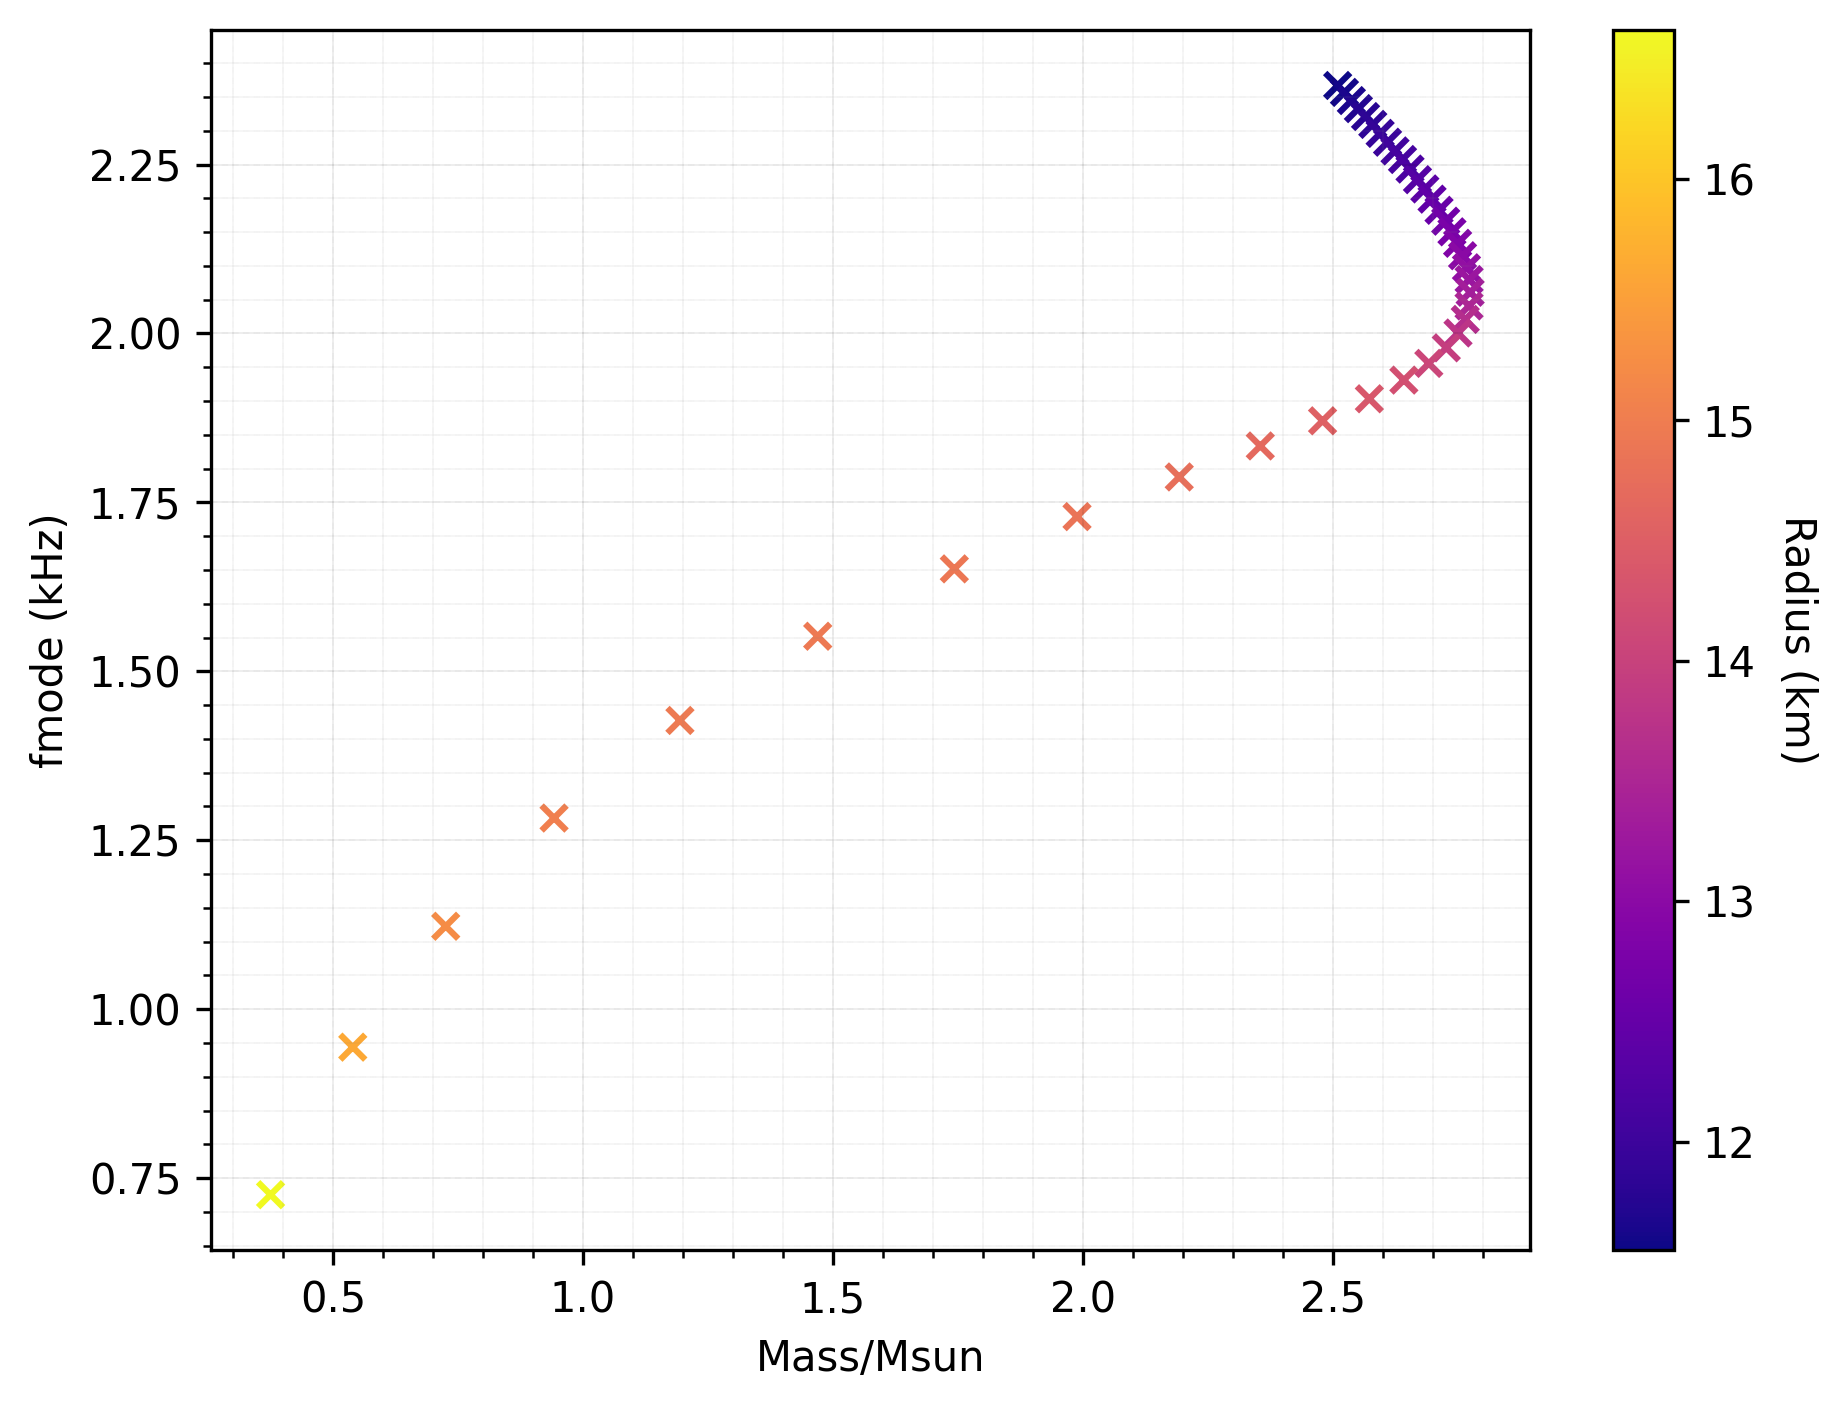

In [10]:
# mass_arr = np.array(mass_list)
# f_mode_arr = np.array(f_mode_list)
# radius_arr = np.array(radius_list)
# hz2khz = 1e-3

plt.figure(dpi = 300)
plt.tight_layout()
plt.scatter(mass_arr/msun, f_mode_arr*hz2khz, c = radius_arr/km2cm, marker = "x", 
            cmap = "plasma")
plt.xlabel("Mass/Msun")
plt.ylabel("fmode (kHz)")
cbar = plt.colorbar()
cbar.set_label('Radius (km)', rotation=-90, labelpad=15)
utkarshGrid()
# plt.xlim(1, 3)
# plt.ylim(1.5, 3)
plt.show()